In [73]:
import pandas as pd

import numpy as np
import datetime

## Read data

We first read the .csv file of our training data into dataframe.

In [74]:
train = pd.read_csv('train_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']

##### Pro Ticker nach dem Download glätten

In [75]:
test = train.loc[train['tic'] == "AAPL"]

In [76]:
test = test[0:250] # aufgrund der langen rechenzeit nur ein Ausschnitt der Daten

In [77]:
test

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754724,7.460152e+08,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,2.754724,2.754724,39.189999,0.0
1,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.870985,1.181608e+09,0.0,0.002608,2.977272,2.648437,100.000000,66.666667,100.000000,2.812854,2.812854,39.080002,0.0
2,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.823632,1.289310e+09,1.0,0.001855,2.933372,2.699522,70.356063,46.850343,100.000000,2.816447,2.816447,38.560001,0.0
3,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.762617,7.530488e+08,2.0,-0.000736,2.912588,2.693391,50.429373,-29.693617,43.607834,2.802989,2.802989,43.389999,0.0
4,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.813918,6.735008e+08,3.0,-0.000087,2.900592,2.709758,60.227187,-9.085592,48.357918,2.805175,2.805175,42.560001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2009-12-22,AAPL,7.122857,7.173214,7.095000,6.081945,3.495156e+08,1.0,-0.007159,6.214930,5.720421,55.486208,12.516819,0.125217,6.041150,5.940594,19.540001,0.0
246,2009-12-23,AAPL,7.185714,7.227857,7.171786,6.134766,3.455256e+08,2.0,0.007133,6.198693,5.729555,56.567396,44.253981,5.184817,6.040260,5.949053,19.709999,0.0
247,2009-12-24,AAPL,7.269643,7.476786,7.262500,6.345428,5.008892e+08,3.0,0.035054,6.243271,5.699699,60.523400,130.171720,23.946889,6.046118,5.961038,19.469999,0.0


In [78]:
# Sort by two columns and calculate the daily log returns for normalized data
#test = train.sort_values(['tic', 'date'],
#              ascending = [True, True])
#test

In [79]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import copy


###### Zeitstempel kopieren und leere Tage auffüllen

In [80]:
index = pd.date_range(start=test["date"].min(), end=test["date"].max(), freq="60T")
df_test = pd.DataFrame()
df_test = df_test.reindex(index, fill_value=np.nan).interpolate()


In [81]:
range(len(index))

range(0, 8665)

##### Timesteps numerisch darstellen

In [82]:
df_test["t_steps"] = range(len(index))

In [83]:
df_test.index

DatetimeIndex(['2009-01-02 00:00:00', '2009-01-02 01:00:00',
               '2009-01-02 02:00:00', '2009-01-02 03:00:00',
               '2009-01-02 04:00:00', '2009-01-02 05:00:00',
               '2009-01-02 06:00:00', '2009-01-02 07:00:00',
               '2009-01-02 08:00:00', '2009-01-02 09:00:00',
               ...
               '2009-12-28 15:00:00', '2009-12-28 16:00:00',
               '2009-12-28 17:00:00', '2009-12-28 18:00:00',
               '2009-12-28 19:00:00', '2009-12-28 20:00:00',
               '2009-12-28 21:00:00', '2009-12-28 22:00:00',
               '2009-12-28 23:00:00', '2009-12-29 00:00:00'],
              dtype='datetime64[ns]', length=8665, freq='60T')

In [84]:
test['date'] = test['date'].astype('datetime64[ns]')

##### Wieder auf alte timesteps (jetzt numerisch) reduzieren

In [85]:
final = pd.merge(test, df_test,  how='left', left_on=['date'], right_on = df_test.index)


In [86]:
final

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,t_steps
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754724,7.460152e+08,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,2.754724,2.754724,39.189999,0.0,0
1,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.870985,1.181608e+09,0.0,0.002608,2.977272,2.648437,100.000000,66.666667,100.000000,2.812854,2.812854,39.080002,0.0,72
2,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.823632,1.289310e+09,1.0,0.001855,2.933372,2.699522,70.356063,46.850343,100.000000,2.816447,2.816447,38.560001,0.0,96
3,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.762617,7.530488e+08,2.0,-0.000736,2.912588,2.693391,50.429373,-29.693617,43.607834,2.802989,2.802989,43.389999,0.0,120
4,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.813918,6.735008e+08,3.0,-0.000087,2.900592,2.709758,60.227187,-9.085592,48.357918,2.805175,2.805175,42.560001,0.0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2009-12-22,AAPL,7.122857,7.173214,7.095000,6.081945,3.495156e+08,1.0,-0.007159,6.214930,5.720421,55.486208,12.516819,0.125217,6.041150,5.940594,19.540001,0.0,8496
246,2009-12-23,AAPL,7.185714,7.227857,7.171786,6.134766,3.455256e+08,2.0,0.007133,6.198693,5.729555,56.567396,44.253981,5.184817,6.040260,5.949053,19.709999,0.0,8520
247,2009-12-24,AAPL,7.269643,7.476786,7.262500,6.345428,5.008892e+08,3.0,0.035054,6.243271,5.699699,60.523400,130.171720,23.946889,6.046118,5.961038,19.469999,0.0,8544
248,2009-12-28,AAPL,7.561429,7.641071,7.486071,6.423443,6.445656e+08,0.0,0.062754,6.324051,5.652370,61.854461,186.405173,33.263381,6.055852,5.976595,19.930000,0.0,8640


In [87]:
#https://stackoverflow.com/questions/61678196/implementing-1d-kalman-filter-smooth-python

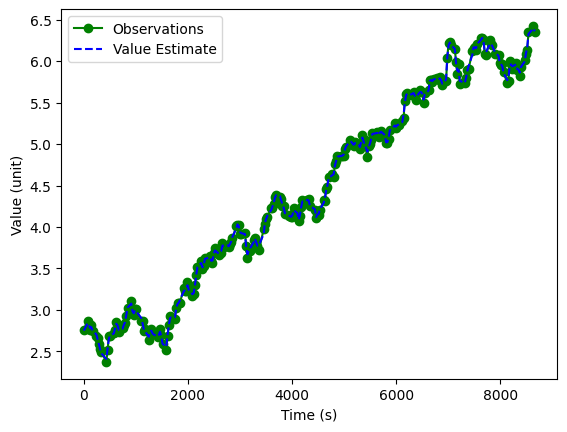

In [88]:
outlier_thresh = 0.9

# Treat y as position, and that y-dot is an unobserved state 

# state vector [y,
#               y_dot]

# transition_matrix =  [[1, dt],
#                       [0, 1]]

observation_matrix = np.asarray([[1, 0]])


# observation time steps:
t = final["t_steps"]

# dt betweeen observations:
dt = [np.mean(np.diff(t))] + list(np.diff(t))
transition_matrices = np.asarray([[[1, each_dt],[0, 1]]
                                    for each_dt in dt])
# observations
y = np.transpose(np.asarray([test['close']]))

y = np.ma.array(y)

leave_1_out_cov = []

for i in range(len(y)):
    y_masked = np.ma.array(copy.deepcopy(y))
    y_masked[i] = np.ma.masked

    kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

    kf1 = kf1.em(y_masked)

    leave_1_out_cov.append(kf1.observation_covariance[0,0])

# Find indexes that contributed excessively to observation covariance
outliers = (leave_1_out_cov / np.mean(leave_1_out_cov)) < outlier_thresh

for i in range(len(outliers)):
    if outliers[i]:
        y[i] = np.ma.masked


kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

kf1 = kf1.em(y)

(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(y)


plt.figure()
plt.plot(t, y, 'go-', label="Observations")
plt.plot(t, smoothed_state_means[:,0], 'b--', label="Value Estimate" )
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Value (unit)")

plt.savefig("test.png")

##### Ersetzen der Closing Werte mit geglätteten

In [91]:
test['close'] = smoothed_state_means[:,0]

##### Berechnen der log returns

In [92]:
test['log_return'] = np.log(test['close']/test['close'].shift(1))
test

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,log_return
,,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.750971,7.460152e+08,4.0,0.000000,2.977272,2.648437,100.000000,66.666667,100.000000,2.754724,2.754724,39.189999,0.0,NaN
1,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.841248,1.181608e+09,0.0,0.002608,2.977272,2.648437,100.000000,66.666667,100.000000,2.812854,2.812854,39.080002,0.0,0.032289
2,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.823561,1.289310e+09,1.0,0.001855,2.933372,2.699522,70.356063,46.850343,100.000000,2.816447,2.816447,38.560001,0.0,-0.006244
3,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.784383,7.530488e+08,2.0,-0.000736,2.912588,2.693391,50.429373,-29.693617,43.607834,2.802989,2.802989,43.389999,0.0,-0.013972
4,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.793248,6.735008e+08,3.0,-0.000087,2.900592,2.709758,60.227187,-9.085592,48.357918,2.805175,2.805175,42.560001,0.0,0.003179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2009-12-22,AAPL,7.122857,7.173214,7.095000,6.092918,3.495156e+08,1.0,-0.007159,6.214930,5.720421,55.486208,12.516819,0.125217,6.041150,5.940594,19.540001,0.0,0.016084
246,2009-12-23,AAPL,7.185714,7.227857,7.171786,6.168745,3.455256e+08,2.0,0.007133,6.198693,5.729555,56.567396,44.253981,5.184817,6.040260,5.949053,19.709999,0.0,0.012368
247,2009-12-24,AAPL,7.269643,7.476786,7.262500,6.326520,5.008892e+08,3.0,0.035054,6.243271,5.699699,60.523400,130.171720,23.946889,6.046118,5.961038,19.469999,0.0,0.025255
